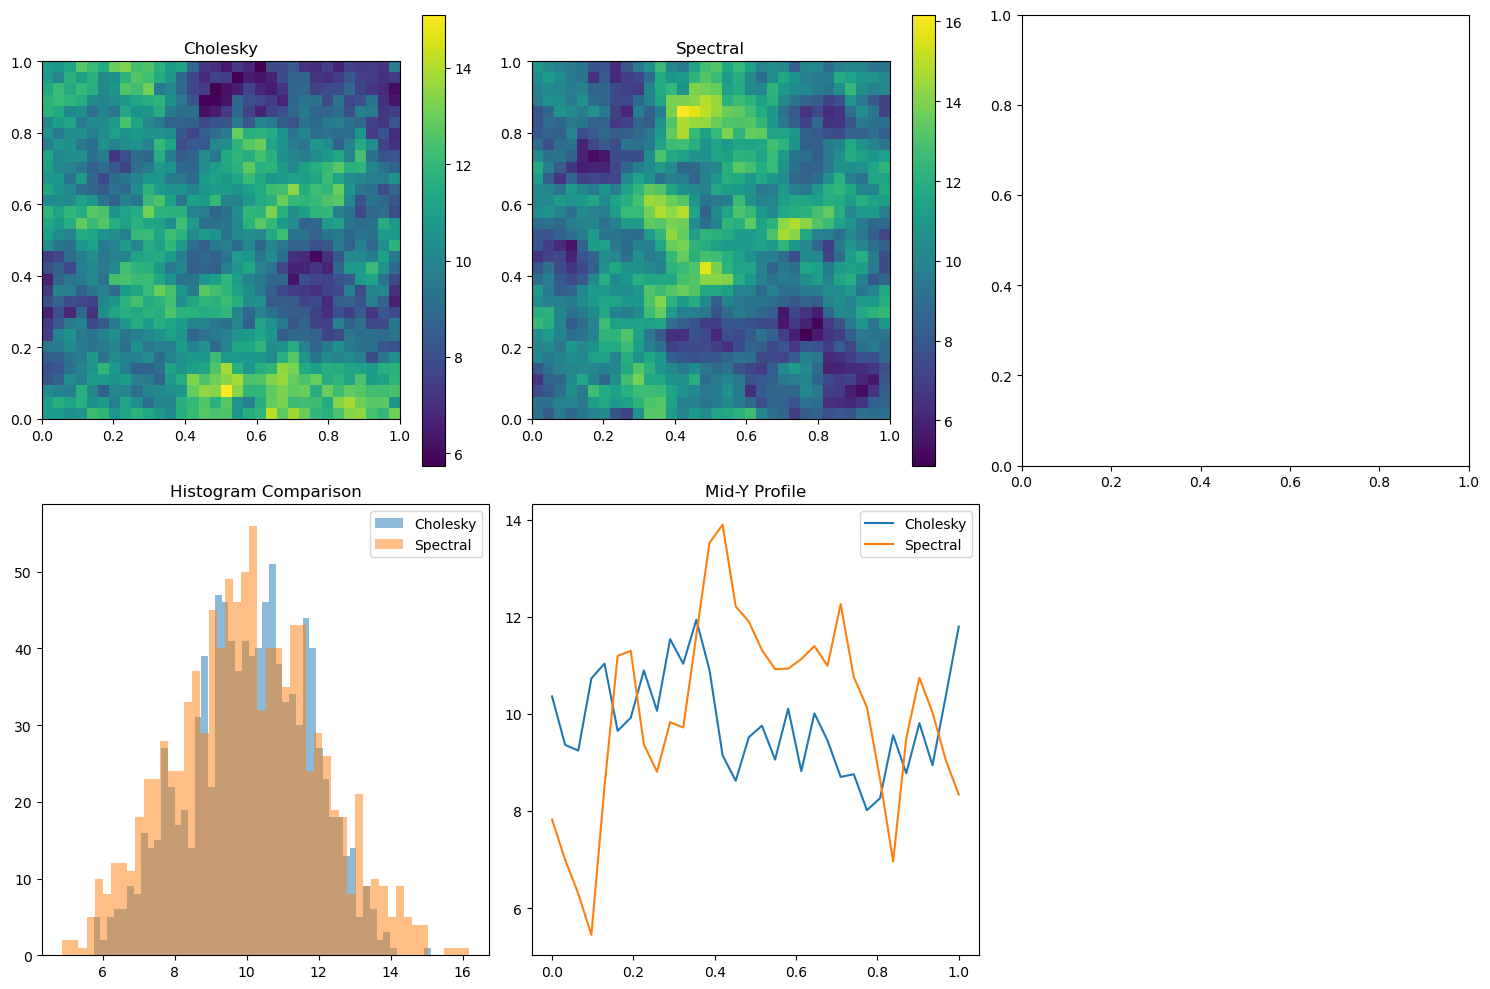

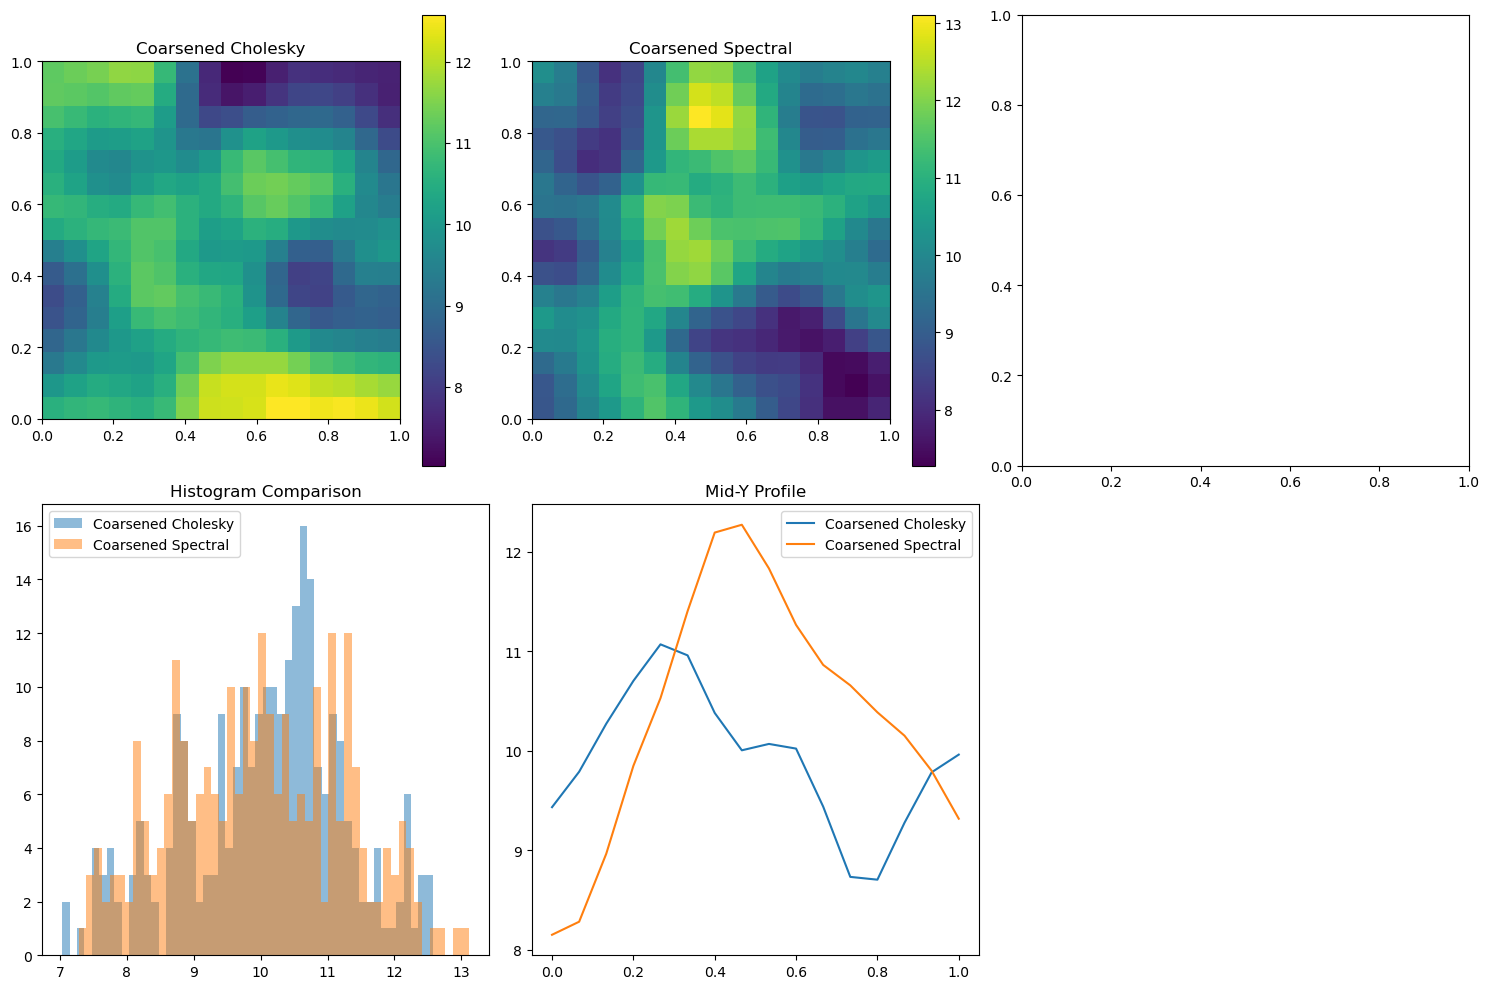

In [7]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from scipy import stats


class RandomFieldGenerator2D:
    def __init__(self, nx=100, ny=100, lx=1.0, ly=1.0):
        self.nx = nx
        self.ny = ny
        self.lx = lx
        self.ly = ly

        self.x = np.linspace(0, lx, nx)
        self.y = np.linspace(0, ly, ny)
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing="ij")
        self.points = np.column_stack((self.X.ravel(), self.Y.ravel()))

    def generate_random_field_cholesky(
        self, mean=10.0, std=2.0, correlation_length=0.2, covariance_type="exponential"
    ):
        """Original method using Cholesky decomposition for comparison."""
        n_points = len(self.points)
        h = cdist(self.points, self.points)
        if covariance_type == "exponential":
            C = np.exp(-h / correlation_length)
        else:
            C = np.exp(-((h / correlation_length) ** 2))
        C += 1e-8 * np.eye(n_points)  # nugget
        L = np.linalg.cholesky(C)
        Z = np.random.normal(0, 1, n_points)
        random_values = mean + std * (L @ Z)
        return random_values.reshape(self.nx, self.ny)

    def generate_random_field(
        self, mean=10.0, std=2.0, correlation_length=0.2, covariance_type="exponential"
    ):
        """Spectral method using FFT for efficient generation."""
        dx = self.lx / (self.nx - 1)
        dy = self.ly / (self.ny - 1)

        # Generate white noise and compute FFT
        white_noise = np.random.normal(0, 1, (self.nx, self.ny))
        fourier_coefficients = np.fft.fft2(white_noise)

        # Compute wavevectors
        kx = 2 * np.pi * np.fft.fftfreq(self.nx, d=dx)
        ky = 2 * np.pi * np.fft.fftfreq(self.ny, d=dy)
        Kx, Ky = np.meshgrid(kx, ky, indexing="ij")
        K = np.sqrt(Kx**2 + Ky**2)

        # Compute power spectrum
        l = correlation_length
        if covariance_type == "exponential":
            P = (2 * np.pi * l**2) / (1 + (l * K) ** 2) ** (1.5)
        elif covariance_type == "gaussian":
            P = np.pi * l**2 * np.exp(-((l * K) ** 2) / 4)
        else:
            raise ValueError("Invalid covariance_type")
        P = np.nan_to_num(P)

        # Scale Fourier coefficients and inverse FFT
        fourier_coefficients *= np.sqrt(P)
        field = np.fft.ifft2(fourier_coefficients).real

        # Normalize to desired mean and std
        field = (field - np.mean(field)) / np.std(field) * std + mean
        return field

    def coarsen_field(
        self, field, filter_sigma=2.0, downsample_factor=2, method="linear"
    ):
        if not isinstance(field, np.ndarray) or field.ndim != 2:
            raise ValueError("Field must be a 2D numpy array")
        smooth = gaussian_filter(field, sigma=filter_sigma)
        ny, nx = smooth.shape
        x = np.linspace(0, 1, nx)
        y = np.linspace(0, 1, ny)
        f = RegularGridInterpolator((y, x), smooth, method=method, bounds_error=False)
        nx_coarse = nx // downsample_factor
        ny_coarse = ny // downsample_factor
        x_coarse = np.linspace(0, 1, nx_coarse)
        y_coarse = np.linspace(0, 1, ny_coarse)
        X_coarse, Y_coarse = np.meshgrid(x_coarse, y_coarse)
        query_points = np.stack((Y_coarse.ravel(), X_coarse.ravel()), axis=-1)
        coarse = f(query_points).reshape(ny_coarse, nx_coarse)
        return coarse

    # def compute_statistics(self, field):
    #     flat_field = field.ravel()
    #     return {
    #         "mean": np.mean(flat_field),
    #         "std": np.std(flat_field),
    #         "skewness": stats.skew(flat_field),
    #         "kurtosis": stats.kurtosis(flat_field),
    #         "min": np.min(flat_field),
    #         "max": np.max(flat_field),
    #         "median": np.median(flat_field),
    #     }

    def compute_correlation_length(self, field):
        norm_field = field - np.mean(field)
        acf_x = np.zeros(norm_field.shape[1])
        for i in range(norm_field.shape[1]):
            acf_x[i] = (
                np.mean(norm_field[:, :-i] * norm_field[:, i:])
                if i > 0
                else np.mean(norm_field**2)
            )
        acf_x /= acf_x[0]
        idx = np.argmin(np.abs(acf_x - 1 / np.e))
        return self.x[idx]

    def plot_comparison(self, field1, field2, title1="Original", title2="Spectral"):
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        for ax, field, title in zip(axes[0], [field1, field2], [title1, title2]):
            im = ax.imshow(field, extent=[0, self.lx, 0, self.ly])
            ax.set_title(title)
            plt.colorbar(im, ax=ax)
        axes[1, 0].hist(field1.ravel(), bins=50, alpha=0.5, label=title1)
        axes[1, 0].hist(field2.ravel(), bins=50, alpha=0.5, label=title2)
        axes[1, 0].legend()
        axes[1, 0].set_title("Histogram Comparison")
        mid = self.nx // 2
        axes[1, 1].plot(self.x, field1[mid, :], label=title1)
        axes[1, 1].plot(self.x, field2[mid, :], label=title2)
        axes[1, 1].legend()
        axes[1, 1].set_title("Mid-Y Profile")
        axes[1, 2].axis("off")

        plt.tight_layout()
        plt.show()


# Example usage and comparison
generator = RandomFieldGenerator2D(nx=32, ny=32)
np.random.seed(42)

# Generate fields using both methods
field_cholesky = generator.generate_random_field_cholesky(
    mean=10, std=2, correlation_length=0.2
)

field_spectral = generator.generate_random_field(mean=10, std=2, correlation_length=0.2)

# Plot comparison
generator.plot_comparison(field_cholesky, field_spectral, "Cholesky", "Spectral")

# Coarsen and compare
coarse_cholesky = generator.coarsen_field(field_cholesky)
coarse_spectral = generator.coarsen_field(field_spectral)
generator_coarse = RandomFieldGenerator2D(nx=16, ny=16)
generator_coarse.plot_comparison(
    coarse_cholesky, coarse_spectral, "Coarsened Cholesky", "Coarsened Spectral"
)
